# Chapter 1

## 1.2.1 Simple Examples

In [1]:
from pyomo.environ import *

In [2]:
model = ConcreteModel()
model.x_1 = Var(within=NonNegativeReals)
model.x_2 = Var(within=NonNegativeReals)
model.obj = Objective(expr = model.x_1 + 2*model.x_2)
model.con1 = Constraint(expr = 3*model.x_1 + 4*model.x_2 >= 1)
model.con2 = Constraint(expr = 2*model.x_1 + 5*model.x_2 >= 2)

opt = SolverFactory('gurobi')
opt.solve(model)

{'Problem': [{'Name': 'x3', 'Lower bound': 0.8, 'Upper bound': 0.8, 'Number of objectives': 1, 'Number of constraints': 3, 'Number of variables': 3, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 3, 'Number of nonzeros': 5, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.00152587890625', 'Error rc': 0, 'Time': 0.12276458740234375}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Concrete Model

In [3]:
import mydata

model = ConcreteModel()
model.x = Var(mydata.N, within=NonNegativeReals)

def obj_rule(model):
    return sum(mydata.c[i]*model.x[i] for i in mydata.N)
model.obj = Objective(rule=obj_rule)

def con_rule(model, m):
    return sum(mydata.a[i,m]*model.x[i] for i in mydata.N) >= mydata.b[m]
model.con = Constraint(mydata.M, rule=con_rule)

Way to see what happens in the function and helps debug the def of Pyomo

In [4]:
for m in mydata.b:
    print(sum(mydata.a[i,m]*model.x[i] for i in mydata.N) >= mydata.b[m])

print('Objective funtion:', model.obj.expr)

1.0  <=  3*x[1] + 2*x[2]
2.0  <=  4*x[1] + 5*x[2]
Objective funtion: x[1] + 2*x[2]


### Abstract Model

In [5]:
model = AbstractModel()

model.N = Set()
model.M = Set()
model.c = Param(model.N)
model.a = Param(model.M, model.N)
model.b = Param(model.N)

model.x = Var(model.N, within=NonNegativeReals)

def obj_rule(model):
    return sum(model.c[i]*model.x[i] for i in model.N)
model.obj = Objective(rule=obj_rule)
print(model.obj)

def con_rule(model, m):
    return sum(model.a[i,m]*model.x[i] for i in model.N) >= mydata.b[m]
model.con = Constraint(mydata.M, rule=con_rule)

obj


# Chapter 2 - Warehouse Example

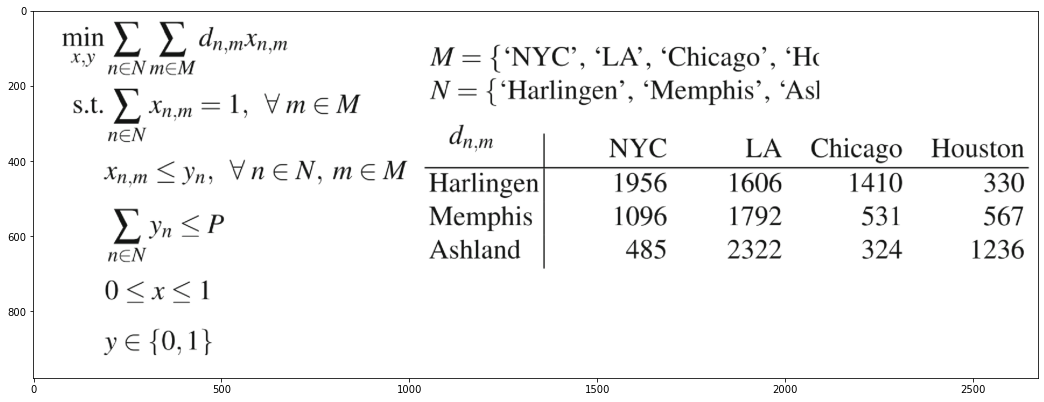

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
img = plt.imread('warehouse_example.png')
plt.imshow(img);

### Concrete example

In [7]:
N = {'Harlingen', 'Memphis', 'Ashland'}
M = {'NYC', 'LA', 'Chicago', 'Houston'}
d = {('Harlingen', 'NYC'): 1956, ('Harlingen', 'LA'): 1606, ('Harlingen', 'Chicago'): 1410, ('Harlingen', 'Houston'): 330, \
    ('Memphis', 'NYC'): 1096, ('Memphis', 'LA'): 1792, ('Memphis', 'Chicago'): 531, ('Memphis', 'Houston'): 567, \
    ('Ashland', 'NYC'): 485, ('Ashland', 'LA'): 2322, ('Ashland', 'Chicago'): 324, ('Ashland', 'Houston'): 1236}
P = 2

model = ConcreteModel(name='(WL)')

In [8]:
# Define decision variables (x(n,m),y(n))
model.x = Var(N, M, bounds=(0,1))
model.y = Var(N, within=Binary)

In [9]:
#---------------------------------------------------------------------------------------------------------
#Add Cost to the Model
#---------------------------------------------------------------------------------------------------------
def obj_rule1(model):
    # sum(for outer(n) for inner(m) loop)
    return(sum(d[n,m]*model.x[n,m] for n in N for m in M))

# def obj_rule2(model):
#     return(sum(sum(d[n,m]*model.x[n,m] for m in M) for n in N))

# def obj_rule3(model):
#     return(sum(d[n,m]*model.x[n,m] for m in M for n in N))

#---------------------------------------------------------------------------------------------------------
#Add Constraints to the Model
#---------------------------------------------------------------------------------------------------------
def one_per_cust_rule(model, m):
    return(sum(model.x[n,m] for n in N) == 1)

def warehouse_active_rule(model, n, m):
    return(model.x[n,m] <= model.y[n])

def num_warehouses_rule(model):
    return(sum(model.y[n] for n in N) <= P)

model.obj1 = Objective(rule=obj_rule1)
#model.obj2 = Objective(rule=obj_rule2)
# model.obj3 = Objective(rule=obj_rule3)
model.one_per_cust = Constraint(M, rule=one_per_cust_rule)
model.warehouse_active = Constraint(N, M, rule=warehouse_active_rule)
model.num_warehouses = Constraint(rule=num_warehouses_rule)

### How to print defined objectives and constraints

In [10]:
print(model.obj1.expr) #, '\n', model.obj2.expr) #, '\n', model.obj3.expr)

2322*x[Ashland,LA] + 1236*x[Ashland,Houston] + 485*x[Ashland,NYC] + 324*x[Ashland,Chicago] + 1792*x[Memphis,LA] + 567*x[Memphis,Houston] + 1096*x[Memphis,NYC] + 531*x[Memphis,Chicago] + 1606*x[Harlingen,LA] + 330*x[Harlingen,Houston] + 1956*x[Harlingen,NYC] + 1410*x[Harlingen,Chicago]


In [11]:
[print(model.one_per_cust._data[m].expr) for m in M];

x[Ashland,LA] + x[Memphis,LA] + x[Harlingen,LA]  ==  1.0
x[Ashland,Houston] + x[Memphis,Houston] + x[Harlingen,Houston]  ==  1.0
x[Ashland,NYC] + x[Memphis,NYC] + x[Harlingen,NYC]  ==  1.0
x[Ashland,Chicago] + x[Memphis,Chicago] + x[Harlingen,Chicago]  ==  1.0


In [12]:
[print(model.warehouse_active._data[n, m].expr) for n in N for m in M];

x[Ashland,LA] - y[Ashland]  <=  0.0
x[Ashland,Houston] - y[Ashland]  <=  0.0
x[Ashland,NYC] - y[Ashland]  <=  0.0
x[Ashland,Chicago] - y[Ashland]  <=  0.0
x[Memphis,LA] - y[Memphis]  <=  0.0
x[Memphis,Houston] - y[Memphis]  <=  0.0
x[Memphis,NYC] - y[Memphis]  <=  0.0
x[Memphis,Chicago] - y[Memphis]  <=  0.0
x[Harlingen,LA] - y[Harlingen]  <=  0.0
x[Harlingen,Houston] - y[Harlingen]  <=  0.0
x[Harlingen,NYC] - y[Harlingen]  <=  0.0
x[Harlingen,Chicago] - y[Harlingen]  <=  0.0


In [13]:
print(model.num_warehouses.expr)

y[Ashland] + y[Memphis] + y[Harlingen]  <=  2.0


In [14]:
solver = SolverFactory('gurobi')
res = solver.solve(model)
model.pprint()

8 Set Declarations
    one_per_cust_index : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=False, Bounds=None
        ['Chicago', 'Houston', 'LA', 'NYC']
    warehouse_active_index : Dim=0, Dimen=2, Size=12, Domain=None, Ordered=False, Bounds=None
        Virtual
    warehouse_active_index_0 : Dim=0, Dimen=1, Size=3, Domain=None, Ordered=False, Bounds=None
        ['Ashland', 'Harlingen', 'Memphis']
    warehouse_active_index_1 : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=False, Bounds=None
        ['Chicago', 'Houston', 'LA', 'NYC']
    x_index : Dim=0, Dimen=2, Size=12, Domain=None, Ordered=False, Bounds=None
        Virtual
    x_index_0 : Dim=0, Dimen=1, Size=3, Domain=None, Ordered=False, Bounds=None
        ['Ashland', 'Harlingen', 'Memphis']
    x_index_1 : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=False, Bounds=None
        ['Chicago', 'Houston', 'LA', 'NYC']
    y_index : Dim=0, Dimen=1, Size=3, Domain=None, Ordered=False, Bounds=None
        ['Ashland', 'Harlingen', 'Memph

In [15]:
[print(model.y._data[n], '=', model.y._data[n].value) for n in N];

y[Ashland] = 1.0
y[Memphis] = -0.0
y[Harlingen] = 1.0


In [16]:
model.y.pprint()

y : Size=3, Index=y_index
    Key       : Lower : Value : Upper : Fixed : Stale : Domain
      Ashland :     0 :   1.0 :     1 : False : False : Binary
    Harlingen :     0 :   1.0 :     1 : False : False : Binary
      Memphis :     0 :  -0.0 :     1 : False : False : Binary


In [17]:
[print(model.x._data[n,m], '=', model.x._data[n,m].value) for n in N for m in M];

x[Ashland,LA] = 0.0
x[Ashland,Houston] = 0.0
x[Ashland,NYC] = 1.0
x[Ashland,Chicago] = 1.0
x[Memphis,LA] = 0.0
x[Memphis,Houston] = 0.0
x[Memphis,NYC] = 0.0
x[Memphis,Chicago] = 0.0
x[Harlingen,LA] = 1.0
x[Harlingen,Houston] = 1.0
x[Harlingen,NYC] = 0.0
x[Harlingen,Chicago] = 0.0


In [18]:
model.x.pprint()

x : Size=12, Index=x_index
    Key                      : Lower : Value : Upper : Fixed : Stale : Domain
      ('Ashland', 'Chicago') :     0 :   1.0 :     1 : False : False :  Reals
      ('Ashland', 'Houston') :     0 :   0.0 :     1 : False : False :  Reals
           ('Ashland', 'LA') :     0 :   0.0 :     1 : False : False :  Reals
          ('Ashland', 'NYC') :     0 :   1.0 :     1 : False : False :  Reals
    ('Harlingen', 'Chicago') :     0 :   0.0 :     1 : False : False :  Reals
    ('Harlingen', 'Houston') :     0 :   1.0 :     1 : False : False :  Reals
         ('Harlingen', 'LA') :     0 :   1.0 :     1 : False : False :  Reals
        ('Harlingen', 'NYC') :     0 :   0.0 :     1 : False : False :  Reals
      ('Memphis', 'Chicago') :     0 :   0.0 :     1 : False : False :  Reals
      ('Memphis', 'Houston') :     0 :   0.0 :     1 : False : False :  Reals
           ('Memphis', 'LA') :     0 :   0.0 :     1 : False : False :  Reals
          ('Memphis', 'NYC') :     0 

In [19]:
# produce nicely formatted output
for wl in N:
    if value(model.y[wl]) > 0.5:
        customers = [cl for cl in M if value(model.x[wl, cl] > 0.5)]
        print(wl, ' serves customers: ', customers)
    else:
        print(wl + ': do not build')
print('\nThe optimal transport cost: ', value(model.obj1),' $')

Ashland  serves customers:  ['NYC', 'Chicago']
Memphis: do not build
Harlingen  serves customers:  ['LA', 'Houston']

The optimal transport cost:  2745.0  $


### Abstract example

In [20]:
model = AbstractModel(name='(WL)')
model.N = Set()
model.M = Set()

model.x = Var(model.N, model.M, bounds=(0,1))
model.y = Var(model.N, within=Binary)

model.d = Param(model.N, model.M, mutable=False)
model.P = Param()

def obj_rule(model):
    return(sum(model.d[n,m]*model.x[n,m] for n in N for m in M))

def one_per_cust_rule(model, m):
    return(sum(model.x[n,m] for n in N) == 1)

def warehouse_active_rule(model, n, m):
    return(model.x[n,m] <= model.y[n])

def num_warehouses_rule(model):
    return(sum(model.y[n] for n in N) <= model.P)

model.obj = Objective(rule=obj_rule)
model.one_per_cust = Constraint(model.M, rule=one_per_cust_rule)
model.warehouse_active = Constraint(model.N, model.M, rule=warehouse_active_rule)
model.num_warehouses = Constraint(rule=num_warehouses_rule)

In [21]:
instance = model.create_instance('w1_data.dat')
solver = SolverFactory('gurobi')
solver.solve(instance)
instance.y.pprint()

y : Size=3, Index=N
    Key       : Lower : Value : Upper : Fixed : Stale : Domain
      Ashland :     0 :   1.0 :     1 : False : False : Binary
    Harlingen :     0 :   1.0 :     1 : False : False : Binary
      Memphis :     0 :  -0.0 :     1 : False : False : Binary


# Capter 4